<a href="https://colab.research.google.com/github/Beh-noush/General-Python/blob/main/Text_classification_with_an_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is to do sentiment classification on IMDB dataset, using RNN models with an LSTM layer. 

#Part 1: Same code as in TensorFlow documentation

In this part, we just use this code from tensorflow tutorials: https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import numpy as np

import tensorflow_datasets as tfds
#import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete300LH8/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete300LH8/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete300LH8/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
BUFFER_SIZE = 10000 
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) #What does prefetching help with?
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Create the text encoder

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

create the model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(train_dataset, epochs=4,
                      validation_data=test_dataset,
                      validation_steps=30)

Epoch 1/4
391/391 [==============================] - 48s 89ms/step - loss: 0.6293 - accuracy: 0.5756 - val_loss: 0.4986 - val_accuracy: 0.7651
Epoch 2/4
391/391 [==============================] - 33s 83ms/step - loss: 0.4443 - accuracy: 0.7821 - val_loss: 0.4319 - val_accuracy: 0.8062
Epoch 3/4
391/391 [==============================] - 33s 84ms/step - loss: 0.3997 - accuracy: 0.8164 - val_loss: 0.3789 - val_accuracy: 0.8339
Epoch 4/4
391/391 [==============================] - 33s 83ms/step - loss: 0.3511 - accuracy: 0.8449 - val_loss: 0.3535 - val_accuracy: 0.8385


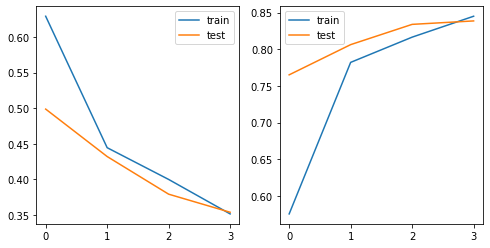

In [ ]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()

Next steps:

1- The same data to be analysed using the Model class instead of Sequential✅ (is done in Part 3)

2- How to do the same example with a pandas dataframe.✅ (is done in Part 2)

3- Run the code on a GPU. (Is done!) ✅ 

#Part 2: Tweaking the code to adapt it to imdb data in .csv file.

We will see that some changes should be made in the code so that we can accomplish the same task as in part 1, with .csv data.

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import *

In [3]:
#importing the data and doing train-test splitting
pd_dataframe = pd.read_csv('IMDB Dataset.csv')
imdb_train, imdb_test = model_selection.train_test_split(pd_dataframe, test_size = .5, shuffle=True)

In [4]:
#To do tokenization using TextVectorization layer of Keras, we first need to load all training text
train_text_from_pandas = imdb_train['review'].tolist()

In [8]:
#What is the max length of a sequence in our training corpus?
seq_len = max([len(i.split()) for i in train_text_from_pandas])
print(f' The longest training sample has {seq_len} words')

 The longest training sample has 2470 words


In [5]:
#doing tokenization by using Keras' TextVectorization
VOCAB_SIZE = 1000 #we just consider the 1000 most frequent words in the training document (max_tokens)
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_text_from_pandas) #we use .adapt method to make our vocabulary out of the training text

In [6]:
assert(len(encoder.get_vocabulary()) == VOCAB_SIZE)
#This verifies that the vocabulary extracted by the encoder has the size that we already set.

In [11]:
#We train the same model as in Part 1
lstm_model = tf.keras.Sequential([
    encoder,             #The encoder is a fixed layer with no learnable parameters
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [12]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-tr

In [28]:
lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #from_logits=True is needed as the output layer of lstm_model is the raw output (no sigmoid)
              optimizer=tf.keras.optimizers.Adam(1e-4), #Note: for the binary classification task, BinaryCrossentropy is the suitable loss
              #function when the output (prediction) is a floating number.
               metrics=['accuracy']) #by setting the variable metrics, we can evaluate our model based on other metrics than loss, like accuracy.

In [14]:
#Finally, to train the model, we need the labels as integers, rather than strings
tag_to_idx = {'positive':1, 'negative':0}
imdb_train['target'] =imdb_train['sentiment'].map(tag_to_idx)
imdb_test['target'] =imdb_test['sentiment'].map(tag_to_idx)

In [23]:
#We first visualize the modified dataframes:
imdb_train.head()

,review,sentiment,target
12202,I actually like this movie even though I don't...,positive,1
6627,Italian horror/suspense film about a wealthy E...,negative,0
13438,The obsession of 'signifie' and 'signifiant' i...,negative,0
3737,Rock n' roll is a messy business and DiG! demo...,positive,1
45095,After a series of power-outages on a remote is...,negative,0


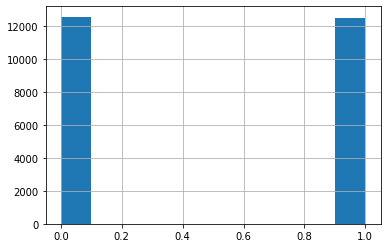

In [25]:
imdb_train['target'].hist()

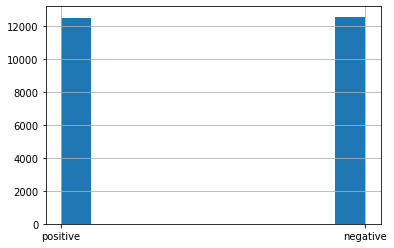

In [26]:
imdb_train['sentiment'].hist()

In [ ]:
#So, now we can fit the model to the training dataset, and evaluate it on the validation data

*****If we run the model on the data as they are right now, we might get an error, to fix that we first need to run the following command: #Without this command: 

tf.data.experimental.enable_debug_mode()

In [ ]:
#Run one of the following commands in case of getting errors while fitting the model.
#tf.config.run_functions_eagerly(True)
#tf.data.experimental.enable_debug_mode()

In [29]:
with tf.device('/device:GPU:0'):
  history = lstm_model.fit(imdb_train['review'],imdb_train['target'], epochs=4, batch_size=100
                      ,validation_data=(imdb_test['review'],imdb_test['target']))


Epoch 1/4
250/250 [==============================] - 46s 135ms/step - loss: 0.6754 - accuracy: 0.5261 - val_loss: 0.5711 - val_accuracy: 0.6595
Epoch 2/4
250/250 [==============================] - 34s 137ms/step - loss: 0.4821 - accuracy: 0.7657 - val_loss: 0.4711 - val_accuracy: 0.7424
Epoch 3/4
250/250 [==============================] - 37s 148ms/step - loss: 0.4056 - accuracy: 0.8103 - val_loss: 0.3711 - val_accuracy: 0.8312
Epoch 4/4
250/250 [==============================] - 35s 139ms/step - loss: 0.3533 - accuracy: 0.8455 - val_loss: 0.3455 - val_accuracy: 0.8503


Text(0.5, 0, 'epoch')

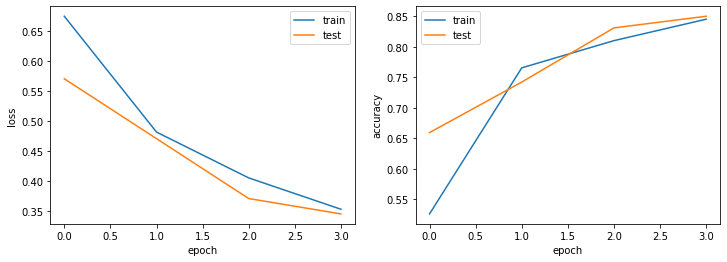

In [33]:
plt.figure(figsize= (12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')


Notice how the different size of training and test sequences was autommatically taken into account by using TexVectorization and .fit() method.

#Part 3: Same experiment as Part 2, using Model class of Keras rather than Sequential. 

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import *

In [4]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer #Instead of TextVectorization, here we use Tokenizer class to do text tokenization
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [3]:
#importing the data and doing train-test splitting
pd_dataframe = pd.read_csv('IMDB Dataset.csv')
imdb_train, imdb_test = model_selection.train_test_split(pd_dataframe, test_size = .5, shuffle=True)

In [6]:
max_vocab_size = 1000
tokenizer = Tokenizer(max_vocab_size)

In [7]:
tokenizer.fit_on_texts(imdb_train['review']) #similar to the .adapt methon in TextVectorization

In [9]:
word2idx = tokenizer.word_index #gives the word2idx dictionary.

In [10]:
vovabulary_size = len(word2idx.keys()) #I thought it will give just 1000 vocab, as specified by max_vocab_size. I should check the documentation
print(f'vocabulary size is {vovabulary_size}')

vocabulary size is 90741


In [11]:
#Now, we can tokenize the training and test corpus:
seq_train = tokenizer.texts_to_sequences(imdb_train['review'])
seq_test = tokenizer.texts_to_sequences(imdb_test['review'])

In [14]:
print( f' the longest test sequence has length {max([len(seq_test[i]) for i in range(len(seq_test))])}')
print( f' the longest train sequence has length {max([len(seq_train[i]) for i in range(len(seq_train))])}')


 the longest test sequence has length 1507
 the longest train sequence has length 1814


In [15]:
#We set the larger value as the max_len for future padding:
max_len = max([max([len(seq[i]) for i in range(len(seq_test))]) for seq in [seq_test,seq_train]])
print(max_len)

1814


In [19]:
seq_train[0][:16]

[5, 1, 13, 27, 4, 1, 84, 12, 10, 66, 338, 16, 559, 5, 916, 2]

In [20]:
seq_test[0][:16]

[18, 37, 1, 19, 4, 105, 613, 11, 19, 982, 14, 69, 8, 1, 18, 29]

In [25]:
#Now, we do padding to get all sequences of the same size, and at the same time make a tf tensor of them. (seq_train and seq_test are nested lists)
train_data = pad_sequences(seq_train, maxlen=max_len, padding= 'post')
test_data = pad_sequences(seq_test, maxlen=max_len, padding = 'post')


In [27]:
test_data[0][:16]

array([ 18,  37,   1,  19,   4, 105, 613,  11,  19, 982,  14,  69,   8,
         1,  18,  29], dtype=int32)

In [28]:
print(f'train data has shape {train_data.shape} and test data has shape {test_data.shape}.')
#So, we see that now all sequences have the same padded length.

train data has shape (25000, 1814) and test data has shape (25000, 1814).


In [29]:
#As before, we add a target column to our dataframe for having numeric label rather than categorical.
tag_to_idx = {'positive':1, 'negative':0}
imdb_train['target'] =imdb_train['sentiment'].map(tag_to_idx)
imdb_test['target'] =imdb_test['sentiment'].map(tag_to_idx)


In [34]:
#Now, the model
embed_dim =64
vocab_size = max(tokenizer.word_index.values())

input = Input(shape= (max_len,)) 
# input = encoder(imdb_train['review'].tolist()[:100]) # seq_len is the (unified) length of sequences
x= Embedding(max_vocab_size, embed_dim)(input)
#x= Embedding(vocab_size, embed_dim)(input)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x) #why return_sequences =True for classification?
x= tf.keras.layers.Dense(64, activation='relu')(x) #maxpool is taken over which dimension?
x=tf.keras.layers.Dense(1)(x)
model_imdb = Model(input,x)


In [35]:
model_imdb.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1814)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 1814, 64)          64000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-trainable params: 0
_____________________________________________________

***Note the same number of to-be-learned parameters as in the Sequential model.

In [36]:
model_imdb.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   optimizer = tf.keras.optimizers.Adam(1e-4), metrics = ['accuracy'])

In [37]:
with tf.device('/device:GPU:0'):
  training = model_imdb.fit(train_data, imdb_train['target'] , validation_data=(test_data, imdb_test['target']), epochs = 4, batch_size= 100)

Epoch 1/4
250/250 [==============================] - 46s 173ms/step - loss: 0.6534 - accuracy: 0.5499 - val_loss: 0.4719 - val_accuracy: 0.7753
Epoch 2/4
250/250 [==============================] - 52s 210ms/step - loss: 0.3972 - accuracy: 0.8180 - val_loss: 0.3548 - val_accuracy: 0.8436
Epoch 3/4
250/250 [==============================] - 51s 205ms/step - loss: 0.3358 - accuracy: 0.8549 - val_loss: 0.3537 - val_accuracy: 0.8619
Epoch 4/4
250/250 [==============================] - 53s 214ms/step - loss: 0.3169 - accuracy: 0.8658 - val_loss: 0.3205 - val_accuracy: 0.8612


Text(0.5, 0, 'epoch')

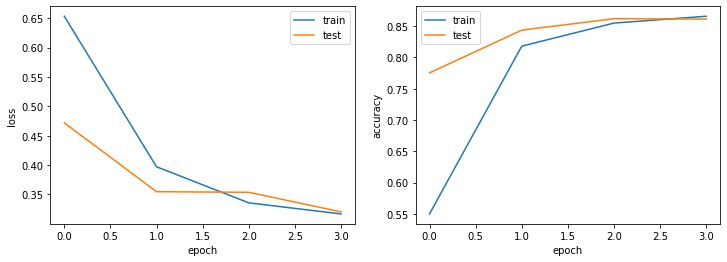

In [39]:
plt.figure(figsize= (12,4))
plt.subplot(1,2,1)
plt.plot(training.history['loss'], label = 'train')
plt.plot(training.history['val_loss'], label = 'test')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend()
plt.subplot(1,2,2)
plt.plot(training.history['accuracy'], label = 'train')
plt.plot(training.history['val_accuracy'], label = 'test')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
